In [30]:
%load_ext autoreload
%autoreload 2

import sys
import pandas as pd

sys.path.append('/Users/lorenzostigliano/Documents/University/Imperial/Summer Term/thesis-imperial/src/')
sys.path.append('/Users/lorenzostigliano/Documents/University/Imperial/Summer Term/thesis-imperial/src/utils')
sys.path.append('/Users/lorenzostigliano/Documents/University/Imperial/Summer Term/thesis-imperial/src/models')

from utils.analysis import *
from utils.getters import * 
from utils.plotters import * 
from models_config.model_config_GSP import *
from models_config.model_config_GSP_emb import *
import matplotlib.pyplot as plt

plt.rcParams['text.latex.preamble']=[r"\usepackage{lmodern}"]
params = {
    'text.usetex' : True,
    'font.size' : 11,
    'font.family' : 'lmodern'
}
plt.rcParams.update(params)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/var/folders/1j/5s36wz6s0jlb1k64vsq1k2zh0000gn/T/ipykernel_78232/4118881939.py:18: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  plt.rcParams['text.latex.preamble']=[r"\usepackage{lmodern}"]


In [22]:
def get_mean_CV_metric_student_model(dataset, model, analysis_type, training_type, view, run, student, dataset_split, model_args):

    import sklearn.metrics as metrics

    #get the mean metric for a student for a particular CV training_type 
    
    student_acc, student_recall, student_precision, student_f1 = 0, 0, 0, 0
    acc_mean, recall_mean, precision_mean, f1_mean = [], [], [], []
    
    if training_type == "3Fold":
        cv_number = 3
    if training_type == "5Fold":
        cv_number = 5
    if training_type == "10Fold":
        cv_number = 10  
    
    for i in range(cv_number):
        x = get_labels_and_preds(dataset=dataset, 
                                model=model,
                                analysis_type=analysis_type, 
                                training_type=training_type,  
                                cv_n=i, 
                                view=view, 
                                run=run, 
                                dataset_split=dataset_split, 
                                student=student, 
                                model_args=model_args)
        result = {
            'prec': metrics.precision_score(x['labels'],  x['preds']),
            'recall': metrics.recall_score(x['labels'],  x['preds']),
            'acc': metrics.accuracy_score(x['labels'],  x['preds']),
            'F1': metrics.f1_score(x['labels'],  x['preds'])
        }   
        acc_mean.append(result['acc'])
        recall_mean.append(result['recall'])
        precision_mean.append(result['prec'])
        f1_mean.append(result['F1'])
    
    student_acc = np.mean(acc_mean)
    student_recall = np.mean(recall_mean)
    student_precision = np.mean(precision_mean)
    student_f1 = np.mean(f1_mean)

    return student_acc, student_f1, student_recall, student_precision

In [23]:
def get_student_model_metric_all_folds(dataset, model, CV, runs, analysis_type, dataset_split, view, model_args):
    #Get average student modele metrics across all runs and all cv for all models in ensemble 
    """
    USAGE:
    runs = [i for i in range(10)]
    CV=["3Fold", "5Fold", "10Fold"]
    model = "gcn_student_ensamble_3"
    analysis_type="model_assessment"
    model_args= gcn_student_ensamble_args
    dataset_split="val"
    view=2

    get_student_model_metric_all_folds(dataset, model, CV, runs, analysis_type, dataset_split, view, model_args)
    """

    all_student_metrics_mean = []
    all_student_metrics_var = []

    for student in range(model_args["n_students"]):

        model_metrics_runs = []
        
        for run in runs:
                
            model_metrics = []
            
            for training_type in CV:
                
                model_metrics.append(get_mean_CV_metric_student_model(
                    dataset=dataset, 
                    model=model, 
                    analysis_type=analysis_type, 
                    training_type=training_type, 
                    view=view, 
                    run=run, 
                    student=student, 
                    dataset_split=dataset_split,
                    model_args=model_args
                )
                )
            
            model_metrics = np.mean(model_metrics, axis=0)
            model_metrics_runs.append(model_metrics)
        all_student_metrics_var.append(np.var(model_metrics_runs, axis=0))
        all_student_metrics_mean.append(np.mean(model_metrics_runs, axis=0))

    return all_student_metrics_mean, all_student_metrics_var


In [24]:
def get_best_student_ensamble(model, view, dataset, CV, runs, dataset_split, analysis_type, model_args):
    import warnings
    warnings.filterwarnings('ignore')
    
    student_rep = []
    student_var = []

    # get the best reproducibility across all runs 
    for run in runs:

        mean_all_runs = []

        for student in range(model_args["n_students"]):
            view_rep, _ = view_reproducibility_analysis(
                dataset=dataset, 
                models=[model], 
                CV=CV, 
                views=[view], 
                run=run, 
                students=[student], 
                model_args=[model_args]
            )
            mean_all_runs.append(view_rep[0][0])
        #store the reproducibility score for all students for the run 
        student_rep.append(mean_all_runs)
    
    #get the mean and variance for the reproducibility scores for all the students
    student_var = np.var(student_rep, axis=0)
    student_rep = np.mean(student_rep, axis=0)

    #get the metrics of all the student models
    all_student_metrics_mean, _ = get_student_model_metric_all_folds(
        dataset=dataset, 
        model=model, 
        CV=CV, 
        runs=runs, 
        analysis_type=analysis_type, 
        dataset_split=dataset_split, 
        view=view, 
        model_args=model_args
    )
    
    #get the best model based soley on max reproducibility 
    best_rep_max = 0
    metric = 0
    student_max = -1
    for i, rep in enumerate(student_rep):
        if rep > metric:
            best_rep_max = rep 
            metric = rep
            student_max = i

    #get the best model based on max reproducibility and accuracy
    best_rep_acc = 0
    metric = 0
    student_acc_index = -1
    for i, rep in enumerate(student_rep):
        student_acc = all_student_metrics_mean[i][0]
        if (rep+student_acc)/2 > metric:
            metric = (rep+student_acc)/2 
            best_rep_acc = rep
            student_acc_index = i
    
    #get the best model based on max reproducibility and f1 score
    best_rep_f1 = 0
    metric = 0
    student_f1_index = -1
    for i, rep in enumerate(student_rep):
        student_f1 = all_student_metrics_mean[i][1]
        if (rep+student_f1)/2 > metric:
            metric = (rep+student_f1)/2 
            best_rep_f1 = rep
            student_f1_index = i
    
    return [best_rep_max, student_var[student_max], student_max], [best_rep_acc, student_var[student_acc_index], student_acc_index], [best_rep_f1, student_var[student_f1_index], student_f1_index]
    

## Overview of the models and ensamble 

In [25]:
def get_student_model_metric(dataset, model, CV, runs, analysis_type, dataset_split, view, model_args):
    #Get average student modele metrics across all runs and all cv for all models in ensemble 
    #EACH FOLD INDIVIDUAL

    student_data_mean = [] 
    student_data_var = [] 
    
    for student in range(model_args["n_students"]):

        run_data = []   

        for run in runs:

            model_metrics = []
            
            for training_type in CV:

                model_cv_metrics = get_mean_CV_metric_student_model(
                    dataset=dataset, 
                    model=model, 
                    analysis_type=analysis_type, 
                    training_type=training_type, 
                    view=view, 
                    run=run, 
                    student=student, 
                    dataset_split=dataset_split,
                    model_args=model_args
                    )
                model_metrics.append(model_cv_metrics)
            
            run_data.append(model_metrics)
        
        student_data_mean.append(np.mean(run_data, axis=0))   
        student_data_var.append(np.std(run_data, axis=0))        

    return student_data_mean, student_data_var

In [26]:
def get_model_metric(dataset, model, CV, runs, analysis_type, dataset_split, view, model_args):
    #Get average metrics across all runs and all cv for any model 
    #EACH FOLD INDIVIDUAL

    data_mean = [] 
    data_var = [] 

    run_data = []   


    for run in runs:

        model_metrics = []
        
        for training_type in CV:
            
            model_cv_metrics = get_mean_CV_metric_student_model(
                dataset=dataset, 
                model=model, 
                analysis_type=analysis_type, 
                training_type=training_type, 
                view=view, 
                run=run, 
                student=-1, 
                dataset_split=dataset_split,
                model_args=model_args
                )
            model_metrics.append(model_cv_metrics)
        
        run_data.append(model_metrics)
        
    data_mean.append(np.mean(run_data, axis=0))   
    data_var.append(np.std(run_data, axis=0))        

    return data_mean, data_var

# REPRODUCIBILITY

In [27]:
def view_reproducibility_analysis_student_specific(dataset, models, CV, views, run, students=[0], model_args=None):
    """
    Reproducibility analysis for a single run for specific students in ensamble 
    student length = number of views, it is the specific student for each view
    """

    view_data_mean = []
    view_data_std = []

    for i, view in enumerate(views):
        
        model_result_mean = []
        model_result_std = []
        ensamble_count = 0

        for j, model in enumerate(models):

            rep_score, std = view_specific_rep(dataset=dataset, view=view, model=model, run=run, CV=CV, student=students[ensamble_count][i], model_args=model_args[j])
            model_result_mean.append(rep_score)
            model_result_std.append(std)
            
            if "ensamble" in models:
                ensamble_count += 1

        view_data_mean.append(model_result_mean)
        view_data_std.append(model_result_std)

    view_data_std.append(list(np.std(view_data_mean, axis=0)))
    view_data_std = np.array(view_data_std).T

    view_data_mean.append(list(np.mean(view_data_mean, axis=0)))

    view_data_mean = np.array(view_data_mean).T
    
    return view_data_mean, view_data_std 

In [28]:
def plot_bar_chart_reproducibility_mulitple_runs_student_specific(dataset, views, models, CV, runs, students=0, model_args=None, save_fig=False):
    """
    USAGE:
    plot_bar_chart_reproducibility_mulitple_runs_student_specific(
    dataset="gender_data", 
    views=[0, 2, 4, 5], 
    models=[  
        "gcn", 
        "gcn_student",
        "gcn_student_teacher",
        "gcn_student_ensamble_3", 
    ], 
    CV=["3Fold", "5Fold", "10Fold"], 
    runs=[i for i in range(10)], 
    students=[2,0,2,0], 
    model_args= [
        gcn_args,
        gcn_student_args,
        gcn_student_args,
        gcn_student_ensamble_args,
    ], 
    save_fig=False
    )
    """
    plt.rcParams["figure.figsize"] = (20,8)

    barWidth = 1/(len(models)+1)

    mean_all_runs = []
    views=[0, 2, 4, 5]
    runs=[i for i in range(10)]
    for run in runs:
        view_data_mean, _ = view_reproducibility_analysis_student_specific(dataset, models, CV, views, run, students=students, model_args=model_args)
        mean_all_runs.append(view_data_mean)

    mean_all_std = np.std(mean_all_runs, axis=0)
    mean_all_runs = np.mean(mean_all_runs, axis=0)
    
    X = np.arange(len(views)+1)

    sep = 0.00
    for i, view_d in enumerate(mean_all_runs):
        if models[i] == "gcn":
            plt.bar(X + sep, view_d, yerr=mean_all_std[i], capsize=4, width = barWidth, edgecolor ='grey', label=models[i]+"_teacher", alpha=0.5)
        elif models[i] == "gcn_student_ensamble_3":
            plt.bar(X + sep, view_d, yerr=mean_all_std[i], capsize=4, width = barWidth, edgecolor ='grey', label="best_student_ensemble", alpha=0.5)
        else:
            plt.bar(X + sep, view_d, yerr=mean_all_std[i], capsize=4, width = barWidth, edgecolor ='grey', label=models[i], alpha=0.5)
        
        sep += barWidth

    max_y_lim = 1 if np.amax(mean_all_runs) + np.max(mean_all_std) > 1 else np.amax(mean_all_runs) + np.max(mean_all_std)
    min_y_lim = 0 if np.amin(mean_all_runs) - np.max(mean_all_std) - 0.01 < 0 else np.amin(mean_all_runs) - np.max(mean_all_std) - 0.01
    plt.ylim(min_y_lim, max_y_lim)

    title = f"Reproducibility Score for Dataset:{dataset} across {len(runs)} different seeds for best student"

    plt.ylabel("Reproducibility Score")
    x_ticks = ["View {}".format(i) for i in views]+ ["Average"]

    plt.xticks([r + barWidth for r in range(len(mean_all_runs[0]))], x_ticks)
    plt.title(title)
    plt.grid(axis = 'y')
    plt.legend()
    if save_fig:
        if not os.path.exists(SAVE_DIR_FIGS+"ensemble_results/"):
            os.makedirs(SAVE_DIR_FIGS+"ensemble_results/")
        
        plt.savefig(SAVE_DIR_FIGS+"ensemble_results/"+title+".png", dpi=150,bbox_inches='tight')
        plt.clf()
    
    else:
        plt.show()
        plt.clf()  

In [29]:
def get_best_student_ensamble_detailed(model, view, CV, runs, dataset_split, analysis_type, model_args):
    import warnings
    warnings.filterwarnings('ignore')
    
    student_rep = []
    student_var = []

    # get the best reproducibility across all runs 
    for run in runs:

        mean_all_runs = []

        for student in range(model_args["n_students"]):
            view_rep, _ = view_reproducibility_analysis(
                dataset=dataset, 
                models=[model], 
                CV=CV, 
                views=[view], 
                run=run, 
                students=[student], 
                model_args=[model_args]
            )
            mean_all_runs.append(view_rep[0][0])
        #store the reproducibility score for all students for the run 
        student_rep.append(mean_all_runs)
    
    #get the mean and variance for the reproducibility scores for all the students
    student_var = np.var(student_rep, axis=0)
    student_rep = np.mean(student_rep, axis=0)

    #get the metrics of all the student models
    all_student_metrics_mean, all_student_metrics_var = get_student_model_metric_all_folds(
        dataset=dataset, 
        model=model, 
        CV=CV, 
        runs=runs, 
        analysis_type=analysis_type, 
        dataset_split=dataset_split, 
        view=view, 
        model_args=model_args
    )
    
    #get the best model based soley on max reproducibility 
    best_rep_max = 0
    metric = 0
    student_max = -1
    for i, rep in enumerate(student_rep):
        if rep > metric:
            best_rep_max = rep 
            metric = rep
            student_max = i

    #get the best model based on max accuracy
    best_max_acc = 0
    metric = 0
    student_max_acc_index = -1
    for i, rep in enumerate(student_rep):
        student_acc = all_student_metrics_mean[i][0]
        if student_acc > metric:
            metric = student_acc
            best_max_acc = rep
            student_max_acc_index = i

    #get the best model based on max reproducibility and f1 score
    best_max_f1 = 0
    metric = 0
    student_max_f1_index = -1
    for i, rep in enumerate(student_rep):
        student_f1 = all_student_metrics_mean[i][1]
        if student_f1 > metric:
            metric = student_f1
            best_max_f1 = rep
            student_max_f1_index = i

    #get the best model based on max reproducibility and accuracy
    best_rep_acc = 0
    metric = 0
    student_acc_index = -1
    for i, rep in enumerate(student_rep):
        student_acc = all_student_metrics_mean[i][0]
        if (rep+student_acc)/2 > metric:
            metric = (rep+student_acc)/2 
            best_rep_acc = rep
            student_acc_index = i
    
    #get the best model based on max reproducibility and f1 score
    best_rep_f1 = 0
    metric = 0
    student_f1_index = -1
    for i, rep in enumerate(student_rep):
        student_f1 = all_student_metrics_mean[i][1]
        if (rep+student_f1)/2 > metric:
            metric = (rep+student_f1)/2 
            best_rep_f1 = rep
            student_f1_index = i
    
    return all_student_metrics_mean, all_student_metrics_var, [[best_rep_max, student_var[student_max], student_max], [best_max_acc, student_var[student_max_acc_index], student_max_acc_index], [best_max_f1, student_var[student_max_f1_index], student_max_f1_index], [best_rep_acc, student_var[student_acc_index], student_acc_index], [best_rep_f1, student_var[student_f1_index], student_f1_index]]
    

# COMPARISON BETWEEN LSP AND LOGITS 

In [32]:
analysis_type="model_assessment"
dataset = "gender_data"
dataset_split="val"
models_args=[
    gcn_student_ensamble_2_args,
    gcn_student_ensamble_3_args,
    gcn_student_ensamble_4_args,
    gcn_student_ensamble_5_args,
    gcn_student_lsp_ensamble_2_args,
    gcn_student_lsp_ensamble_3_args,
    gcn_student_lsp_ensamble_4_args,
    gcn_student_lsp_ensamble_5_args,
    gcn_student_emb_ensamble_2_args,
    gcn_student_emb_ensamble_3_args,
    gcn_student_emb_ensamble_4_args,
    gcn_student_emb_ensamble_5_args
]

all_model_data_mean = []
all_model_data_std = []

for model_arg in models_args:
    
    model_data_mean = []
    model_data_std = []
    
    print(model_arg["model_name"])
    
    for view in [0,2,4,5]:
        
        rep = get_best_student_ensamble(
            model=model_arg["model_name"], 
            dataset=dataset,
            view=view, 
            CV=["3Fold", "5Fold", "10Fold"],
            runs=[i for i in range(10)], 
            analysis_type=analysis_type,
            dataset_split=dataset_split,
            model_args=model_arg
        )[1]
        model_data_mean.append(rep[0])
        model_data_std.append(rep[1])
    
    all_model_data_mean.append(model_data_mean)
    all_model_data_std.append(model_data_std)

gcn_student_ensamble_2
gcn_student_ensamble_3
gcn_student_ensamble_4
gcn_student_ensamble_5
gcn_student_lsp_ensamble_2
gcn_student_lsp_ensamble_3
gcn_student_lsp_ensamble_4
gcn_student_lsp_ensamble_5
gcn_student_emb_ensamble_2
gcn_student_emb_ensamble_3
gcn_student_emb_ensamble_4
gcn_student_emb_ensamble_5


In [33]:
df = pd.DataFrame(all_model_data_mean)

df_transposed = df.T
# Calculate the mean along each column
mean_row = df_transposed.mean()

# Add the mean row to the transposed DataFrame
df_transposed = df_transposed.append(mean_row, ignore_index=True)
print(df_transposed.head())

         0         1         2         3         4         5         6   \
0  0.940556  0.968750  0.972222  0.965278  0.938333  0.968333  0.960000   
1  0.929722  0.932083  0.953056  0.941667  0.944444  0.931944  0.968889   
2  0.943889  0.957778  0.961111  0.975556  0.957917  0.966667  0.965000   
3  0.946111  0.912639  0.955278  0.937778  0.933056  0.921667  0.969028   
4  0.940069  0.942813  0.960417  0.955069  0.943437  0.947153  0.965729   

         7         8         9         10        11  
0  0.958056  0.885833  0.914722  0.934306  0.928750  
1  0.978333  0.898750  0.928333  0.935556  0.938750  
2  0.977222  0.869583  0.913750  0.921667  0.907500  
3  0.933750  0.916806  0.941250  0.929444  0.959722  
4  0.961840  0.892743  0.924514  0.930243  0.933681  


In [34]:
df = pd.DataFrame(np.sqrt(all_model_data_std))

df_transposed_var = df.T
# Calculate the mean along each column
std_row = df_transposed.std()

# Add the mean row to the transposed DataFrame
df_std_transposed = df_transposed_var.append(std_row, ignore_index=True)
df_std_transposed

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.022229,0.004270,0.017213,0.024256,0.018584,0.007265,0.019173,0.020230,0.060816,0.050186,0.054013,0.043444
1,0.018934,0.028467,0.022608,0.015726,0.019355,0.014055,0.007713,0.008498,0.083801,0.043133,0.048759,0.038871
2,0.026074,0.010323,0.011785,0.014530,0.017624,0.008607,0.011055,0.009027,0.066363,0.041156,0.060385,0.055064
3,0.019011,0.018028,0.011749,0.019343,0.018276,0.009091,0.013945,0.019355,0.057091,0.051333,0.028190,0.031975
4,0.006293,0.021922,0.007424,0.015831,0.009280,0.020678,0.003682,0.018111,0.017315,0.011252,0.005452,0.018799


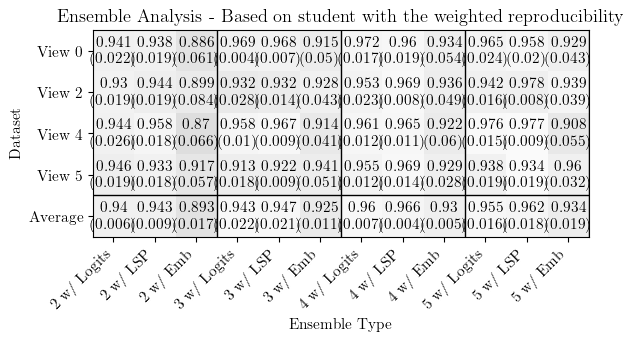

In [42]:
import matplotlib.pyplot as plt
import numpy as np

# Change the order of the DataFrame columns
column_order = [0, 4, 8, 1, 5, 9, 2, 6, 10, 3, 7, 11]
df_ordered = df_transposed.iloc[:, column_order]
df_std_ordered = df_std_transposed.iloc[:, column_order]

# Create a white heatmap with a grayscale colormap
plt.imshow(df_ordered.values, cmap='gray', extent=[-0.5, df_ordered.shape[1] - 0.5, -0.5, df_ordered.shape[0] - 0.5], vmin=0, vmax=1)

# Find the maximum value for each pair of rows and round to 3 significant figures
max_values = []
for i in range(0, df.shape[0], 2):
    pair_max = max(df.iloc[i:i+2])
    pair_max_rounded = round(pair_max, 3)
    max_values.append(pair_max_rounded)

# Iterate over the DataFrame and highlight the maximum value for each pair in the "Average" row
for i in range(df_ordered.shape[0]):
    for j in range(df_ordered.shape[1]):
        value = round(df_ordered.values[i, j], 3)  # Round to 3 significant figures
        std = round(df_std_ordered.values[i, j], 3)  # Round standard deviation to 3 significant figures
        if i == 4 and value in max_values:
            plt.text(j, i, f'{value}\n({std})', ha='center', va='center', color='black', weight='bold')
        else:
            plt.text(j, i, f'{value}\n({std})', ha='center', va='center', color='black')



plt.axhline(3.5, color='black', linewidth=1)  # Add a horizontal line on top of the "Average" row

# Add vertical lines spaced 2 cells apart
for j in range(2, df_ordered.shape[1], 3):
    plt.axvline(j + 0.5, color='black', linewidth=1)  # Add a vertical line in the middle of each pair


plt.gca().invert_yaxis()  # Reverse the y-axis

# Add custom labels to the y-axis
labels = ['View 0', 'View 2', 'View 4', 'View 5', 'Average']
plt.yticks(range(df_ordered.shape[0]), labels)

# Add custom labels to the x-axis
x_ticks = ['2 w/ Logits', '2 w/ LSP', '2 w/ Emb', '3 w/ Logits', '3 w/ LSP', '3 w/ Emb', '4 w/ Logits', '4 w/ LSP', '4 w/ Emb','5 w/ Logits', '5 w/ LSP', '5 w/ Emb']
plt.xticks(range(df_ordered.shape[1]), x_ticks, rotation=45, ha='right')

# Add title and axis labels
plt.title('Ensemble Analysis - Based on student with the weighted reproducibility')
plt.xlabel('Ensemble Type')
plt.ylabel('Dataset')
if not os.path.exists(SAVE_DIR_FIGS+"ensemble_results/"):
    os.makedirs(SAVE_DIR_FIGS+"ensemble_results/")
plt.savefig(SAVE_DIR_FIGS+"ensemble_results/"+'Ensemble Analysis - Based on student with the average reproducibility'+".png", dpi=150,bbox_inches='tight')

plt.show()


In [43]:
analysis_type="model_assessment"
dataset_split="val"
models_args=[
    gcn_student_ensamble_2_args,
    gcn_student_ensamble_3_args,
    gcn_student_ensamble_4_args,
    gcn_student_ensamble_5_args,
    gcn_student_lsp_ensamble_2_args,
    gcn_student_lsp_ensamble_3_args,
    gcn_student_lsp_ensamble_4_args,
    gcn_student_lsp_ensamble_5_args,
    gcn_student_emb_ensamble_2_args,
    gcn_student_emb_ensamble_3_args,
    gcn_student_emb_ensamble_4_args,
    gcn_student_emb_ensamble_5_args
]

all_model_metrics_mean = []
all_model_metrics_var = []
all_model_best_student = []

for model_arg in models_args:
    
    print(model_arg["model_name"])

    model_metrics_mean = []
    model_metrics_var = []
    model_best_student = []

    for view in [0,2,4,5]:
        mean, var, best_students = get_best_student_ensamble_detailed(
            model=model_arg["model_name"], 
            view=view, 
            CV=["3Fold", "5Fold", "10Fold"],
            runs=[i for i in range(10)], 
            analysis_type=analysis_type,
            dataset_split=dataset_split,
            model_args=model_arg
        )
        print(best_students)
        model_metrics_mean.append(mean)
        model_metrics_var.append(var)
        model_best_student.append(best_students)

    all_model_metrics_mean.append(model_metrics_mean)
    all_model_metrics_var.append(model_metrics_var)
    all_model_best_student.append(model_best_student)

gcn_student_ensamble_2
[[0.9405555555555555, 0.000494135802469136, 0], [0.9405555555555555, 0.000494135802469136, 0], [0.9156944444444445, 0.0005571180555555544, 1], [0.9405555555555555, 0.000494135802469136, 0], [0.9156944444444445, 0.0005571180555555544, 1]]
[[0.9297222222222221, 0.0003584876543209886, 0], [0.8902777777777778, 0.0001358024691358015, 1], [0.8902777777777778, 0.0001358024691358015, 1], [0.9297222222222221, 0.0003584876543209886, 0], [0.8902777777777778, 0.0001358024691358015, 1]]
[[0.943888888888889, 0.0006798611111111126, 1], [0.943888888888889, 0.0006798611111111126, 1], [0.943888888888889, 0.0006798611111111126, 1], [0.943888888888889, 0.0006798611111111126, 1], [0.943888888888889, 0.0006798611111111126, 1]]
[[0.946111111111111, 0.000361419753086421, 1], [0.946111111111111, 0.000361419753086421, 1], [0.946111111111111, 0.000361419753086421, 1], [0.946111111111111, 0.000361419753086421, 1], [0.946111111111111, 0.000361419753086421, 1]]
gcn_student_ensamble_3
[[0.9687

In [51]:
df_best_student = np.array(all_model_best_student)
df = []
for i in range(4):
    df.append(df_best_student[:, i, :, 0].flatten())
df = pd.DataFrame(np.array(df))
# Calculate the mean of columns
mean_row = df.mean(axis=0)

# Append the mean row to the DataFrame
df = df.append(mean_row, ignore_index=True).T
index_values = ['max rep', 'max acc', 'max f1', 'weighted acc', 'weighted f1'] * (len(df) // 5) + ['max rep', 'max acc', 'max f1', 'weighted acc', 'weighted f1'][:len(df) % 5]

# Assign the new index to the DataFrame
df.index = index_values
df.shape

(60, 5)

In [52]:
index = df_best_student[:,:,:,2]
all_data_accuracy = []
for view_index in range(4):
    view_data = []
    ensamble_indexes = index[:,view_index,:]
    ensamble_data = np.array(all_model_metrics_mean)[:,view_index]
    #number of ensembles 
    for i in range(12):
        view_data.append([ensamble_data[i][int(best_student_index)][0] for best_student_index in ensamble_indexes[i]])
    all_data_accuracy.append(np.array(view_data).flatten())

In [53]:
all_data_var = []
for view_index in range(4):
    view_data = []
    ensamble_indexes = index[:,view_index,:]
    ensamble_data = np.array(all_model_metrics_var)[:,view_index]
    #number of ensembles 
    for i in range(12):
        view_data.append([ensamble_data[i][int(best_student_index)][0] for best_student_index in ensamble_indexes[i]])
    all_data_var.append(np.array(view_data).flatten())

In [54]:
df_acuracy = pd.DataFrame(np.array(all_data_accuracy))
# Calculate the mean of columns
mean_row = df_acuracy.mean(axis=0)

# Append the mean row to the DataFrame
df_acuracy = df_acuracy.append(mean_row, ignore_index=True).T
# Create the list of repeating index values
index_values = ['max rep', 'max acc', 'max f1', 'weighted acc', 'weighted f1'] * (len(df_acuracy) // 5) + ['max rep', 'max acc', 'max f1', 'weighted acc', 'weighted f1'][:len(df_acuracy) % 5]

# Assign the new index to the DataFrame
df_acuracy.index = index_values
df_acuracy.shape

(60, 5)

In [55]:
df_var = pd.DataFrame(np.array(all_data_var))
# Calculate the mean of columns
mean_row = df_var.mean(axis=0)

# Append the mean row to the DataFrame
df_var = df_var.append(mean_row, ignore_index=True).T
# Create the list of repeating index values
index_values = ['max rep', 'max acc', 'max f1', 'weighted acc', 'weighted f1'] * (len(df_var) // 5) + ['max rep', 'max acc', 'max f1', 'weighted acc', 'weighted f1'][:len(df_var) % 5]

# Assign the new index to the DataFrame
df_var.index = index_values
df_var.shape

(60, 5)

In [56]:
df_acuracy = df_acuracy.loc['weighted acc'].T
df_var = df_var.loc['weighted acc'].T
df_var = np.sqrt(df_var)

In [57]:
import pandas as pd

# Assuming you have a DataFrame called 'df' with the given data

# Define the new column labels
new_labels = ['2 w/ Logits', '3 w/ Logits', '4 w/ Logits','5 w/ Logits', '2 w/ LSP', '3 w/ LSP', '4 w/ LSP',  '5 w/ LSP', '2 w/ Emb', '3 w/ Emb', '4 w/ Emb', '5 w/ Emb']
# Rename the columns using the new labels
df_acuracy.columns = new_labels
df_var.columns = new_labels
# Display the modified DataFrame
df_var

,2 w/ Logits,3 w/ Logits,4 w/ Logits,5 w/ Logits,2 w/ LSP,3 w/ LSP,4 w/ LSP,5 w/ LSP,2 w/ Emb,3 w/ Emb,4 w/ Emb,5 w/ Emb
0,0.005647,0.007414,0.010266,0.006060,0.004220,0.005999,0.009602,0.007251,0.011593,0.015470,0.014313,0.018952
1,0.002587,0.003368,0.003574,0.003366,0.003084,0.007322,0.004146,0.002374,0.027539,0.016357,0.022066,0.021206
2,0.006626,0.004166,0.002682,0.005347,0.005716,0.002912,0.002405,0.002883,0.035569,0.021288,0.019270,0.017886
3,0.004202,0.004929,0.004669,0.003748,0.003754,0.005351,0.003948,0.005817,0.035896,0.024392,0.032659,0.012662
4,0.005003,0.005195,0.006065,0.004762,0.004304,0.005628,0.005718,0.005009,0.029354,0.019717,0.023074,0.017952


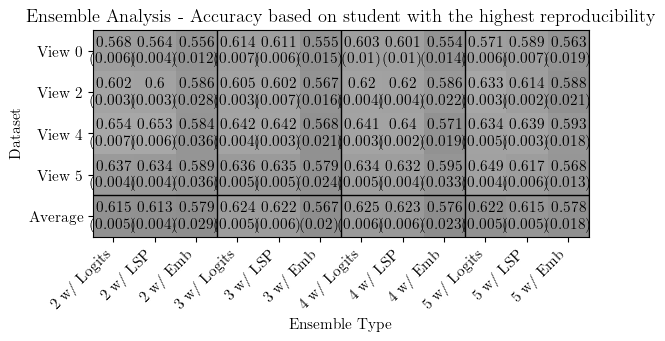

In [61]:
import matplotlib.pyplot as plt
import numpy as np

# Change the order of the DataFrame columns
column_order = [0, 4, 8, 1, 5, 9, 2, 6, 10, 3, 7, 11]
df_ordered = df_acuracy.iloc[:, column_order]
df_std_ordered = df_var.iloc[:, column_order]
# Create a white heatmap with a grayscale colormap
plt.imshow(df_ordered.values, cmap='gray', extent=[-0.5, df_ordered.shape[1] - 0.5, -0.5, df_ordered.shape[0] - 0.5], vmin=0, vmax=1)

# Find the maximum value for each pair of rows and round to 3 significant figures
max_values = []
for i in range(0, df_ordered.T.shape[0], 2):
    pair_max = max(df_ordered.iloc[4].iloc[i:i+2])
    pair_max_rounded = round(pair_max, 3)
    max_values.append(pair_max_rounded)
    
# Iterate over the DataFrame and highlight the maximum value for each pair in the "Average" row
for i in range(df_ordered.shape[0]):
    for j in range(df_ordered.shape[1]):
        value = round(df_ordered.values[i, j], 3)  # Round to 3 significant figures
        std = round(df_std_ordered.values[i, j], 3)  # Round standard deviation to 3 significant figures
        if i == 4 and value in max_values:
            plt.text(j, i, f'{value}\n({std})', ha='center', va='center', color='black', weight='bold')
        else:
            plt.text(j, i, f'{value}\n({std})', ha='center', va='center', color='black')

plt.axhline(3.5, color='black', linewidth=1)  # Add a horizontal line on top of the "Average" row

# Add vertical lines spaced 2 cells apart
for j in range(2, df_ordered.shape[1], 3):
    plt.axvline(j + 0.5, color='black', linewidth=1)  # Add a vertical line in the middle of each pair


plt.gca().invert_yaxis()  # Reverse the y-axis

# Add custom labels to the y-axis
labels = ['View 0', 'View 2', 'View 4', 'View 5', 'Average']
plt.yticks(range(df_ordered.shape[0]), labels)

# Add custom labels to the x-axis
x_ticks = ['2 w/ Logits', '2 w/ LSP', '2 w/ Emb', '3 w/ Logits', '3 w/ LSP', '3 w/ Emb', '4 w/ Logits', '4 w/ LSP', '4 w/ Emb','5 w/ Logits', '5 w/ LSP', '5 w/ Emb']
plt.xticks(range(df_ordered.shape[1]), x_ticks, rotation=45, ha='right')

# Add title and axis labels
plt.title('Ensemble Analysis - Accuracy based on student with the highest reproducibility')
plt.xlabel('Ensemble Type')
plt.ylabel('Dataset')

if not os.path.exists(SAVE_DIR_FIGS+"ensemble_results/"):
    os.makedirs(SAVE_DIR_FIGS+"ensemble_results/")
plt.savefig(SAVE_DIR_FIGS+"ensemble_results/"+'Ensemble Analysis - Accuracy based on student with the weighted reproducibility'+".png", dpi=150,bbox_inches='tight')

plt.show()

## HOW TO PICK THE BEST STUDENT 

In [96]:
def get_best_student_ensamble_detailed(model, view, CV, runs, dataset_split, analysis_type, model_args):
    import warnings
    warnings.filterwarnings('ignore')
    
    student_rep = []
    student_var = []

    # get the best reproducibility across all runs 
    for run in runs:

        mean_all_runs = []

        for student in range(model_args["n_students"]):
            view_rep, _ = view_reproducibility_analysis(
                dataset=dataset, 
                models=[model], 
                CV=CV, 
                views=[view], 
                run=run, 
                students=[student], 
                model_args=[model_args]
            )
            mean_all_runs.append(view_rep[0][0])
        #store the reproducibility score for all students for the run 
        student_rep.append(mean_all_runs)
    
    #get the mean and variance for the reproducibility scores for all the students
    student_var = np.var(student_rep, axis=0)
    student_rep = np.mean(student_rep, axis=0)

    #get the metrics of all the student models
    all_student_metrics_mean, all_student_metrics_var = get_student_model_metric_all_folds(
        dataset=dataset, 
        model=model, 
        CV=CV, 
        runs=runs, 
        analysis_type=analysis_type, 
        dataset_split=dataset_split, 
        view=view, 
        model_args=model_args
    )
    
    #get the best model based soley on max reproducibility 
    best_rep_max = 0
    metric = 0
    student_max = -1
    for i, rep in enumerate(student_rep):
        if rep > metric:
            best_rep_max = rep 
            metric = rep
            student_max = i

    #get the best model based on max accuracy
    best_max_acc = 0
    metric = 0
    student_max_acc_index = -1
    for i, rep in enumerate(student_rep):
        student_acc = all_student_metrics_mean[i][0]
        if student_acc > metric:
            metric = student_acc
            best_max_acc = rep
            student_max_acc_index = i

    #get the best model based on max reproducibility and f1 score
    best_max_f1 = 0
    metric = 0
    student_max_f1_index = -1
    for i, rep in enumerate(student_rep):
        student_f1 = all_student_metrics_mean[i][1]
        if student_f1 > metric:
            metric = student_f1
            best_max_f1 = rep
            student_max_f1_index = i

    #get the best model based on max reproducibility and accuracy
    best_rep_acc = 0
    metric = 0
    student_acc_index = -1
    for i, rep in enumerate(student_rep):
        student_acc = all_student_metrics_mean[i][0]
        if (rep+student_acc)/2 > metric:
            metric = (rep+student_acc)/2 
            best_rep_acc = rep
            student_acc_index = i
    
    #get the best model based on max reproducibility and f1 score
    best_rep_f1 = 0
    metric = 0
    student_f1_index = -1
    for i, rep in enumerate(student_rep):
        student_f1 = all_student_metrics_mean[i][1]
        if (rep+student_f1)/2 > metric:
            metric = (rep+student_f1)/2 
            best_rep_f1 = rep
            student_f1_index = i
    
    return all_student_metrics_mean, all_student_metrics_var, [[best_rep_max, student_var[student_max], student_max], [best_max_acc, student_var[student_max_acc_index], student_max_acc_index], [best_max_f1, student_var[student_max_f1_index], student_max_f1_index], [best_rep_acc, student_var[student_acc_index], student_acc_index], [best_rep_f1, student_var[student_f1_index], student_f1_index]]
    

In [97]:
from models.model_config import *

analysis_type="model_assessment"
dataset_split="val"
models_args=[
    gcn_student_lsp_ensamble_2_args,
    gcn_student_lsp_ensamble_3_args,
    gcn_student_lsp_ensamble_4_args,
    gcn_student_lsp_ensamble_5_args
]

all_model_metrics_mean = []
all_model_metrics_var = []
all_model_best_student = []

for model_arg in models_args:
    
    print(model_arg["model_name"])

    model_metrics_mean = []
    model_metrics_var = []
    model_best_student = []

    for view in [0,2,4,5]:
        mean, var, best_students = get_best_student_ensamble_detailed(
            model=model_arg["model_name"], 
            view=view, 
            CV=["3Fold", "5Fold", "10Fold"],
            runs=[i for i in range(10)], 
            analysis_type=analysis_type,
            dataset_split=dataset_split,
            model_args=model_arg
        )
        print(best_students)
        model_metrics_mean.append(mean)
        model_metrics_var.append(var)
        model_best_student.append(best_students)

    all_model_metrics_mean.append(model_metrics_mean)
    all_model_metrics_var.append(model_metrics_var)
    all_model_best_student.append(model_best_student)


gcn_student_lsp_ensamble_2
[[0.9384722222222223, 0.00025889274691358056, 1], [0.9383333333333332, 0.0003453703703703699, 0], [0.9384722222222223, 0.00025889274691358056, 1], [0.9383333333333332, 0.0003453703703703699, 0], [0.9384722222222223, 0.00025889274691358056, 1]]
[[0.9444444444444444, 0.00037461419753086217, 0], [0.8927777777777777, 0.0002483796296296277, 1], [0.8927777777777777, 0.0002483796296296277, 1], [0.9444444444444444, 0.00037461419753086217, 0], [0.8927777777777777, 0.0002483796296296277, 1]]
[[0.9579166666666667, 0.00031059027777777855, 1], [0.9579166666666667, 0.00031059027777777855, 1], [0.9579166666666667, 0.00031059027777777855, 1], [0.9579166666666667, 0.00031059027777777855, 1], [0.9579166666666667, 0.00031059027777777855, 1]]
[[0.9577777777777777, 0.0002234567901234572, 0], [0.9330555555555555, 0.0003340277777777791, 1], [0.9330555555555555, 0.0003340277777777791, 1], [0.9330555555555555, 0.0003340277777777791, 1], [0.9330555555555555, 0.0003340277777777791, 1]]

In [98]:
#Model, view, how to pick, [rep, std, index]
df_best_student = np.array(all_model_best_student)

In [99]:
df = []
for i in range(4):
    df.append(df_best_student[:, i, :, 0].flatten())
df = pd.DataFrame(np.array(df))
# Calculate the mean of columns
mean_row = df.mean(axis=0)

# Append the mean row to the DataFrame
df = df.append(mean_row, ignore_index=True).T
index_values = ['max rep', 'max acc', 'max f1', 'weighted acc', 'weighted f1'] * (len(df) // 5) + ['max rep', 'max acc', 'max f1', 'weighted acc', 'weighted f1'][:len(df) % 5]

# Assign the new index to the DataFrame
df.index = index_values
df

,0,1,2,3,4
max rep,0.938472,0.944444,0.957917,0.957778,0.949653
max acc,0.938333,0.892778,0.957917,0.933056,0.930521
max f1,0.938472,0.892778,0.957917,0.933056,0.930556
weighted acc,0.938333,0.944444,0.957917,0.933056,0.943437
weighted f1,0.938472,0.892778,0.957917,0.933056,0.930556
max rep,0.969028,0.931944,0.966667,0.956111,0.955937
max acc,0.968333,0.896667,0.932222,0.921667,0.929722
max f1,0.968333,0.896667,0.966667,0.921667,0.938333
weighted acc,0.968333,0.931944,0.966667,0.921667,0.947153
weighted f1,0.968333,0.896667,0.966667,0.921667,0.938333


In [100]:
index = df_best_student[:,:,:,2]
all_data_accuracy = []
for view_index in range(4):
    view_data = []
    ensamble_indexes = index[:,view_index,:]
    ensamble_data = np.array(all_model_metrics_mean)[:,view_index]
    #number of ensembles 
    for i in range(4):
        view_data.append([ensamble_data[i][int(best_student_index)][0] for best_student_index in ensamble_indexes[i]])
    all_data_accuracy.append(np.array(view_data).flatten())


In [101]:
df_acuracy = pd.DataFrame(np.array(all_data_accuracy))
# Calculate the mean of columns
mean_row = df_acuracy.mean(axis=0)

# Append the mean row to the DataFrame
df_acuracy = df_acuracy.append(mean_row, ignore_index=True).T
# Create the list of repeating index values
index_values = ['max rep', 'max acc', 'max f1', 'weighted acc', 'weighted f1'] * (len(df_acuracy) // 5) + ['max rep', 'max acc', 'max f1', 'weighted acc', 'weighted f1'][:len(df_acuracy) % 5]

# Assign the new index to the DataFrame
df_acuracy.index = index_values
df_acuracy

,0,1,2,3,4
max rep,0.535898,0.600378,0.653475,0.600888,0.597660
max acc,0.563971,0.636689,0.653475,0.633602,0.621934
max f1,0.535898,0.636689,0.653475,0.633602,0.614916
weighted acc,0.563971,0.600378,0.653475,0.633602,0.612857
weighted f1,0.535898,0.636689,0.653475,0.633602,0.614916
max rep,0.533604,0.601620,0.641890,0.588522,0.591409
max acc,0.611339,0.625489,0.653350,0.634708,0.631222
max f1,0.611339,0.625489,0.641890,0.634708,0.628357
weighted acc,0.611339,0.601620,0.641890,0.634708,0.622390
weighted f1,0.611339,0.625489,0.641890,0.634708,0.628357


In [102]:
max_value = df_acuracy[:5][4].values.max()
max_indices_acc = np.where(df_acuracy[:5][4].values == max_value)

max_value = df[:5][4].values.max()
max_indices_rep = np.where(df[:5][4].values == max_value)

max_indices_acc, max_indices_rep

((array([1]),), (array([0]),))

In [103]:
max_value = df_acuracy[5:10][4].values.max()
max_indices_acc = np.where(df_acuracy[5:10][4].values == max_value)

max_value = df[5:10][4].values.max()
max_indices_rep = np.where(df[5:10][4].values == max_value)

max_indices_acc, max_indices_rep

((array([1]),), (array([0]),))

In [104]:
max_value = df_acuracy[10:15][4].values.max()
max_indices_acc = np.where(df_acuracy[10:15][4].values == max_value)

max_value = df[10:15][4].values.max()
max_indices_rep = np.where(df[10:15][4].values == max_value)

max_indices_acc, max_indices_rep

((array([1]),), (array([0, 2, 3, 4]),))

In [105]:
ensamble_4_acc = df_acuracy[10:15]
ensamble_4_rep = df[10:15]
ensamble_4_acc

,0,1,2,3,4
max rep,0.601303,0.619532,0.640231,0.631901,0.623242
max acc,0.601303,0.623435,0.646875,0.631901,0.625879
max f1,0.601303,0.619532,0.640231,0.631901,0.623242
weighted acc,0.601303,0.619532,0.640231,0.631901,0.623242
weighted f1,0.601303,0.619532,0.640231,0.631901,0.623242


In [106]:
ensamble_4_rep

,0,1,2,3,4
max rep,0.96,0.968889,0.965000,0.969028,0.965729
max acc,0.96,0.930694,0.914306,0.969028,0.943507
max f1,0.96,0.968889,0.965000,0.969028,0.965729
weighted acc,0.96,0.968889,0.965000,0.969028,0.965729
weighted f1,0.96,0.968889,0.965000,0.969028,0.965729


In [107]:
max_value = df_acuracy[15:20][4].values.max()
max_indices_acc = np.where(df_acuracy[15:20][4].values == max_value)

max_value = df[15:20][4].values.max()
max_indices_rep = np.where(df[15:20][4].values == max_value)

max_indices_acc, max_indices_rep

((array([1]),), (array([0]),))

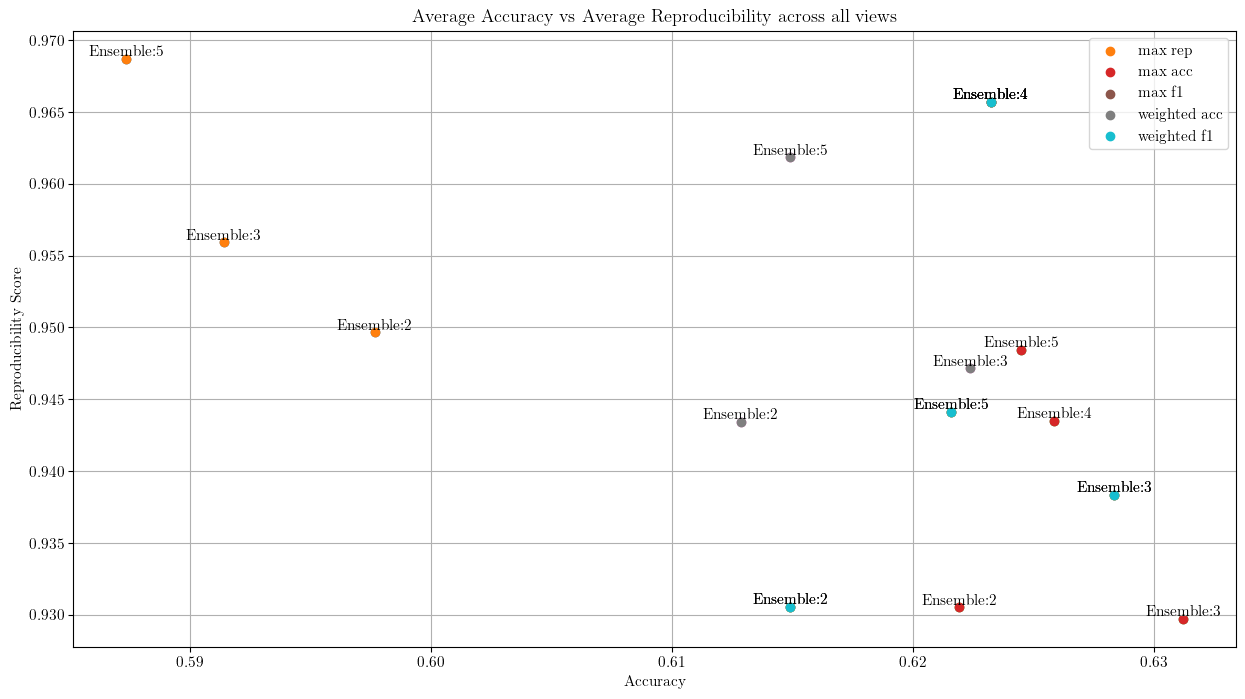

In [108]:
import matplotlib.pyplot as plt
import pandas as pd

plt.rcParams["figure.figsize"] = (15,8)
all_x = []
all_y = []

for method in ['max rep', 'max acc', 'max f1', 'weighted acc', 'weighted f1']:
    # Assuming you have two DataFrames: df1 and df2
    # Let's say you want to plot column 'A' from df1 against column 'B' from df2
    labels = ["2", "3", "4", "5"]
    # Extract the columns of interest from the DataFrames
    x, y = df_acuracy.loc[method][4], df.loc[method][4]
    plt.scatter(x, y)

    # Create the scatter plot
    plt.scatter(x, y, label=method)

    # Add labels to each point
    for index, (i, j) in enumerate(zip(x, y)):
        plt.text(i, j, f'Ensemble:{labels[index]}', ha='center', va='bottom')
    # Customize the plot
    plt.xlabel('Accuracy')  # Add x-axis label
    plt.ylabel('Reproducibility Score')  # Add y-axis label
    plt.title(f'Average Accuracy vs Average Reproducibility across all views')  # Add title
    plt.grid()
    plt.legend()
    all_x.append(x)
    all_y.append(y)

if not os.path.exists(SAVE_DIR_FIGS+"ensemble_results/"):
    os.makedirs(SAVE_DIR_FIGS+"ensemble_results/")
plt.savefig(SAVE_DIR_FIGS+"ensemble_results/"+'Average Accuracy vs Average Reproducibility across all views'+".png", dpi=150,bbox_inches='tight')

plt.show()  # Show the plot

In [109]:
x = sum([x.tolist() for x in all_x], [])
y = sum([y.tolist() for y in all_y], [])
correlation_coefficient = np.corrcoef(x, y)[0, 1]
correlation_coefficient

-0.32042291884733676

# COMPARISON WITH OTHER METHODS

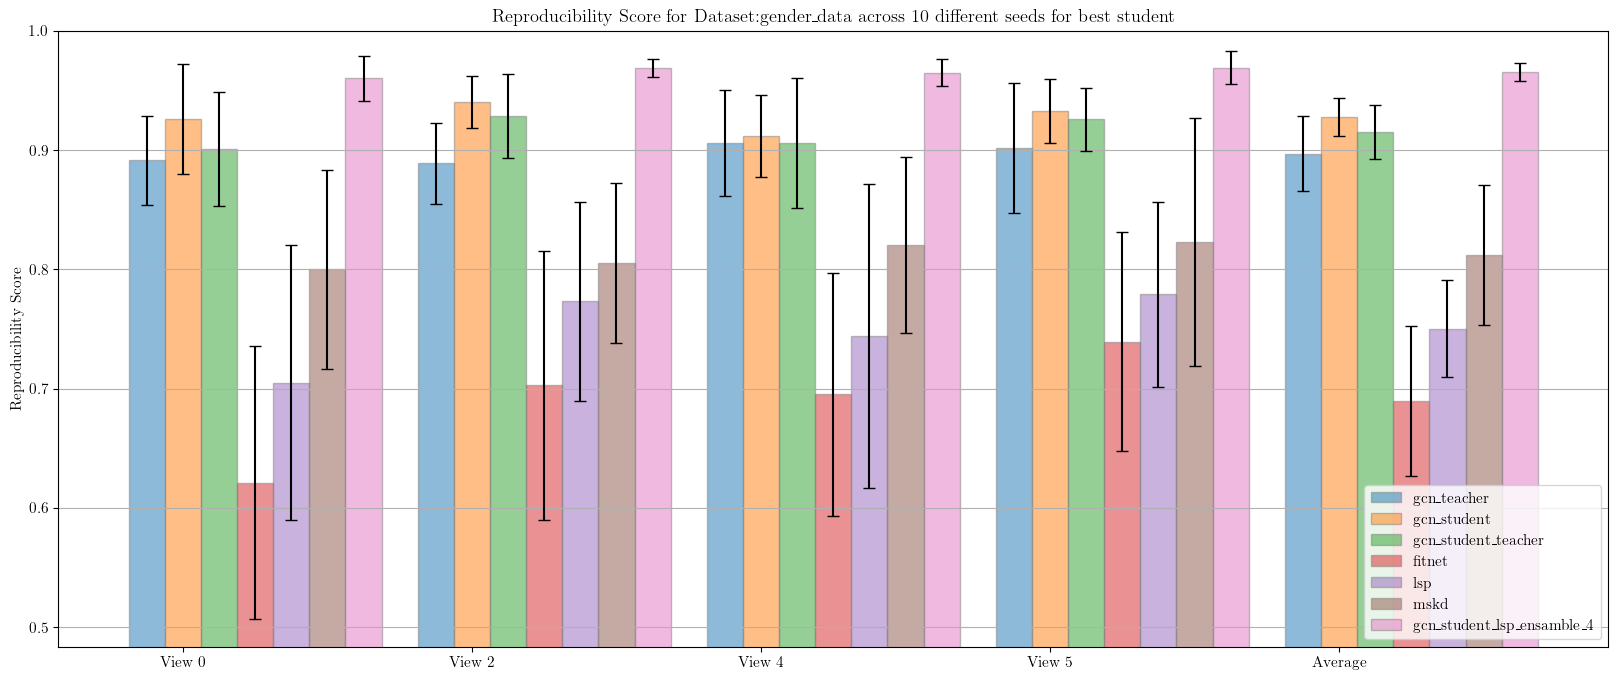

<Figure size 2000x800 with 0 Axes>

In [125]:
plot_bar_chart_reproducibility_mulitple_runs_student_specific(
    dataset="gender_data", 
    views=[0, 2, 4, 5], 
    models=[  
        "gcn", 
        "gcn_student",
        "gcn_student_teacher",
        "fitnet", 
        "lsp", 
        "mskd",
        "gcn_student_lsp_ensamble_4"
    ], 
    CV=["3Fold", "5Fold", "10Fold"], 
    runs=[i for i in range(10)], 
    students=[
        [2,1,2,1],
        [2,1,2,1]
    ], 
    model_args= [
        gcn_args,
        gcn_student_args,
        gcn_student_args, 
        gcn_fitnet_student_args, 
        gcn_lsp_student_args, 
        gcn_mskd_student_args,
        gcn_student_lsp_ensamble_4_args,
    ], 
    save_fig=False
)

In [62]:
def reproducibility_mulitple_runs_student_specific(dataset, views, models, CV, runs, students=0, model_args=None):

    mean_all_runs = []
    views=[0, 2, 4, 5]
    runs=[i for i in range(10)]
    for run in runs:
        view_data_mean, _ = view_reproducibility_analysis_student_specific(dataset, models, CV, views, run, students=students, model_args=model_args)
        mean_all_runs.append(view_data_mean)

    mean_all_std = np.std(mean_all_runs, axis=0)
    mean_all_runs = np.mean(mean_all_runs, axis=0)
    
    return mean_all_runs, mean_all_std

In [63]:
mean_all_runs, mean_all_std = reproducibility_mulitple_runs_student_specific(
    dataset="gender_data", 
    views=[0, 2, 4, 5], 
    models=[  
        "gcn", 
        "gcn_student",
        "gcn_student_teacher",
        "fitnet", 
        "lsp", 
        "mskd",
        "gcn_student_lsp_ensamble_4" 
    ], 
    CV=["3Fold", "5Fold", "10Fold"], 
    runs=[i for i in range(10)], 
    students=[
        [2,1,2,1],
        [2,1,2,1]
    ], 
    model_args= [
        gcn_args,
        gcn_student_args,
        gcn_student_args, 
        gcn_fitnet_student_args, 
        gcn_lsp_student_args, 
        gcn_mskd_student_args,
        gcn_student_lsp_ensamble_4_args
    ])

In [64]:
mean_all_runs, mean_all_std

(array([[0.89138889, 0.88875   , 0.90597222, 0.90166667, 0.89694444],
        [0.92597222, 0.94041667, 0.91166667, 0.93291667, 0.92774306],
        [0.90069444, 0.92847222, 0.90569444, 0.92583333, 0.91517361],
        [0.635     , 0.70277778, 0.67861111, 0.73930556, 0.68892361],
        [0.70486111, 0.77305556, 0.74402778, 0.77916667, 0.75027778],
        [0.82444444, 0.81847222, 0.78611111, 0.79458333, 0.80590278],
        [0.96      , 0.96888889, 0.965     , 0.96902778, 0.96572917]]),
 array([[0.03737531, 0.0338812 , 0.04468274, 0.05456336, 0.03138927],
        [0.04644811, 0.02196421, 0.03407848, 0.02696055, 0.01628206],
        [0.04762593, 0.0353021 , 0.05428566, 0.02627314, 0.02296767],
        [0.08245088, 0.11256   , 0.10113019, 0.09168571, 0.06401246],
        [0.11524975, 0.08329444, 0.12748767, 0.07741483, 0.04074999],
        [0.04523686, 0.07274398, 0.09169402, 0.11048338, 0.05176057],
        [0.0191727 , 0.00771302, 0.01105542, 0.01394503, 0.00751646]]))

In [77]:
reproducibility_frame_std = pd.DataFrame(mean_all_std.T)
models=[  
    "gcn", 
    "gcn_student",
    "gcn_student_teacher",
    "fitnet", 
    "lsp", 
    "mskd",
    #"gcn_student_ensamble_4",
    "gcn_student_lsp_ensamble_4" 
]
reproducibility_frame_std.columns = models
reproducibility_frame_std.T*100

,0,1,2,3,4
gcn,3.737531,3.388120,4.468274,5.456336,3.138927
gcn_student,4.644811,2.196421,3.407848,2.696055,1.628206
gcn_student_teacher,4.762593,3.530210,5.428566,2.627314,2.296767
fitnet,8.245088,11.256000,10.113019,9.168571,6.401246
lsp,11.524975,8.329444,12.748767,7.741483,4.074999
mskd,4.523686,7.274398,9.169402,11.048338,5.176057
gcn_student_lsp_ensamble_4,1.917270,0.771302,1.105542,1.394503,0.751646


In [68]:
reproducibility_frame = pd.DataFrame(mean_all_runs.T)
reproducibility_frame

,0,1,2,3,4,5,6
0,0.891389,0.925972,0.900694,0.635000,0.704861,0.824444,0.960000
1,0.888750,0.940417,0.928472,0.702778,0.773056,0.818472,0.968889
2,0.905972,0.911667,0.905694,0.678611,0.744028,0.786111,0.965000
3,0.901667,0.932917,0.925833,0.739306,0.779167,0.794583,0.969028
4,0.896944,0.927743,0.915174,0.688924,0.750278,0.805903,0.965729


In [69]:
models=[  
    "gcn", 
    "gcn_student",
    "gcn_student_teacher",
    "fitnet", 
    "lsp", 
    "mskd",
    #"gcn_student_ensamble_4",
    "gcn_student_lsp_ensamble_4" 
]
reproducibility_frame.columns = models

"""
reproducibility_frame["delta teacher"] = ((reproducibility_frame["gcn_student_ensamble_4"] - reproducibility_frame["gcn"]) / reproducibility_frame["gcn"])*100
reproducibility_frame["delta student"] = ((reproducibility_frame["gcn_student_ensamble_4"] - reproducibility_frame["gcn_student"]) / reproducibility_frame["gcn_student"])*100
"""

reproducibility_frame["delta teacher"] = ((reproducibility_frame["gcn_student_lsp_ensamble_4"] - reproducibility_frame["gcn"]) / reproducibility_frame["gcn"])*100
reproducibility_frame["delta student"] = ((reproducibility_frame["gcn_student_lsp_ensamble_4"] - reproducibility_frame["gcn_student"]) / reproducibility_frame["gcn_student"])*100
reproducibility_frame["delta vanilla"] = ((reproducibility_frame["gcn_student_lsp_ensamble_4"] - reproducibility_frame["gcn_student_teacher"]) / reproducibility_frame["gcn_student_teacher"])*100
reproducibility_frame["delta fitnet"] = ((reproducibility_frame["gcn_student_lsp_ensamble_4"] - reproducibility_frame["fitnet"]) / reproducibility_frame["fitnet"])*100
reproducibility_frame["delta lsp"] = ((reproducibility_frame["gcn_student_lsp_ensamble_4"] - reproducibility_frame["lsp"]) / reproducibility_frame["lsp"])*100
reproducibility_frame["delta mskd"] = ((reproducibility_frame["gcn_student_lsp_ensamble_4"] - reproducibility_frame["mskd"]) / reproducibility_frame["mskd"])*100

In [72]:
reproducibility_frame.T*100

,0,1,2,3,4
gcn,89.138889,88.875000,90.597222,90.166667,89.694444
gcn_student,92.597222,94.041667,91.166667,93.291667,92.774306
gcn_student_teacher,90.069444,92.847222,90.569444,92.583333,91.517361
fitnet,63.500000,70.277778,67.861111,73.930556,68.892361
lsp,70.486111,77.305556,74.402778,77.916667,75.027778
mskd,82.444444,81.847222,78.611111,79.458333,80.590278
gcn_student_lsp_ensamble_4,96.000000,96.888889,96.500000,96.902778,96.572917
delta teacher,769.710190,901.703391,651.540702,747.073321,766.878290
delta student,367.481626,302.761778,585.009141,387.077564,409.446461
delta vanilla,658.442560,435.302917,654.807545,466.546655,552.414918


In [78]:
views=[0, 2, 4, 5]
CV=["3Fold", "5Fold", "10Fold"]
#model = ["gcn_student_ensamble_4", "gcn_student_lsp_ensamble_4"]
model = ["gcn_student_lsp_ensamble_4"]
runs = [i for i in range(10)]
dataset = "gender_data"
dataset_split="val"
analysis_type="model_assessment"
metrics = ["acc"]
#model_args= [gcn_student_ensamble_4_args, gcn_student_lsp_ensamble_4_args]
model_args= [gcn_student_lsp_ensamble_4_args]

best_student = [2,1,2,1]
#best_student_4_lsp = [2,1,2,1]

view_mean = []
view_std = []
    
for best_student_i, view in enumerate(views):

    models = ["gcn", "gcn_student", "gcn_student_teacher", "fitnet", "lsp", "mskd"]
    mean_all_runs = []
    for run in [i for i in range(10)]:
        view_data_mean, _ = view_metric_analysis(models=models, CV=CV, view=view, run=run, metric="acc", dataset=dataset, 
                                                 dataset_split=dataset_split, analysis_type=analysis_type, model_args= [
                                                                                                                gcn_args,
                                                                                                                gcn_student_args,
                                                                                                                gcn_student_args, 
                                                                                                                gcn_fitnet_student_args, 
                                                                                                                gcn_lsp_student_args, 
                                                                                                                gcn_mskd_student_args
                                                                                                            ]
                                                                                                        )
        mean_all_runs.append(view_data_mean)

    mean_all_std = np.std(mean_all_runs, axis=0).squeeze()
    mean_all_runs = np.mean(mean_all_runs, axis=0).squeeze()

    index_student = best_student[best_student_i]

    model_mean = []
    model_std = []

    for i, model_arg in enumerate(model_args):
        mean, std = get_student_model_metric(dataset, model[i], CV, runs, analysis_type, dataset_split, view, model_arg)
        model_mean.append(mean[index_student])
        model_std.append(std[index_student])
    
    for i, metric in enumerate(metrics):
        print("____________________________________________________")
        print(f"View: {view} Metric: {metric}")        
    

        mean_df = np.array(model_mean[0])[:,i]
        mean_df = mean_df[np.newaxis, :]
        
        std_df = np.array(model_std[0])[:,i]
        std_df = std_df[np.newaxis, :]
        
        final_mean_df = np.r_[mean_all_runs, mean_df]
        final_var_df = np.r_[mean_all_std, std_df]
        """
        mean_df = np.array(model_mean[1])[:,i]
        mean_df = mean_df[np.newaxis, :]
    
        std_df = np.array(model_std[1])[:,i]
        std_df = std_df[np.newaxis, :]
        
        final_mean_df = np.r_[final_mean_df, mean_df]
        final_var_df = np.r_[final_var_df, std_df]        
        """

    view_mean.append(np.c_[ final_mean_df, np.mean(final_mean_df, axis=1)])
    view_std.append(np.c_[ final_var_df, np.std(final_var_df, axis=1)])

____________________________________________________
View: 0 Metric: acc
____________________________________________________
View: 2 Metric: acc
____________________________________________________
View: 4 Metric: acc
____________________________________________________
View: 5 Metric: acc


In [79]:
average_across_views = []
for i in range(4):
    average_across_views.append(view_mean[i][:,-1])

In [81]:
average_across_views_df = pd.DataFrame(average_across_views)
# Assuming you have a DataFrame named 'df'
average_across_views_df_mean = average_across_views_df.mean(axis=0)  # Calculate the mean of each row
average_across_views_df_mean = pd.DataFrame(average_across_views_df_mean).T  # Create a DataFrame from the row means

# Append the row mean DataFrame to the original DataFrame
average_across_views_df = average_across_views_df.append(average_across_views_df_mean, ignore_index=True)

# Display the DataFrame with the added row
average_across_views_df*100

,0,1,2,3,4,5,6
0,61.010917,57.784444,58.161648,60.725618,61.209564,62.182683,60.130316
1,66.158171,63.747176,63.981767,64.208859,65.579805,65.721309,61.953215
2,66.906934,63.248662,63.754955,65.195896,66.425911,66.507907,64.023050
3,65.441907,63.622665,63.765708,64.446336,65.784582,65.786443,63.190064
4,64.879482,62.100737,62.416019,63.644177,64.749965,65.049585,62.324161


In [82]:
average_across_views_df = pd.DataFrame(average_across_views_df)
models=[  
    "gcn", 
    "gcn_student",
    "gcn_student_teacher",
    "fitnet", 
    "lsp", 
    "mskd",
    #"gcn_student_ensamble_4",
    "gcn_student_lsp_ensamble_4" 
]
average_across_views_df.columns = models
"""
average_across_views_df["delta teacher"] = ((average_across_views_df["gcn_student_ensamble_4"] - average_across_views_df["gcn"]) / average_across_views_df["gcn"])*100
average_across_views_df["delta student"] = ((average_across_views_df["gcn_student_ensamble_4"] - average_across_views_df["gcn_student"]) / average_across_views_df["gcn_student"])*100
"""

average_across_views_df["delta teacher"] = ((average_across_views_df["gcn_student_lsp_ensamble_4"] - average_across_views_df["gcn"]) / average_across_views_df["gcn"])*100
average_across_views_df["delta student"] = ((average_across_views_df["gcn_student_lsp_ensamble_4"] - average_across_views_df["gcn_student"]) / average_across_views_df["gcn_student"])*100
average_across_views_df["delta vanilla"] = ((average_across_views_df["gcn_student_lsp_ensamble_4"] - average_across_views_df["gcn_student_teacher"]) / average_across_views_df["gcn_student_teacher"])*100
average_across_views_df["delta fitnet"] = ((average_across_views_df["gcn_student_lsp_ensamble_4"] - average_across_views_df["fitnet"]) / average_across_views_df["fitnet"])*100
average_across_views_df["delta lsp"] = ((average_across_views_df["gcn_student_lsp_ensamble_4"] - average_across_views_df["lsp"]) / average_across_views_df["lsp"])*100
average_across_views_df["delta mskd"] = ((average_across_views_df["gcn_student_lsp_ensamble_4"] - average_across_views_df["mskd"]) / average_across_views_df["mskd"])*100

In [86]:
average_across_views_df.T*100

,0,1,2,3,4
gcn,61.010917,66.158171,66.906934,65.441907,64.879482
gcn_student,57.784444,63.747176,63.248662,63.622665,62.100737
gcn_student_teacher,58.161648,63.981767,63.754955,63.765708,62.416019
fitnet,60.725618,64.208859,65.195896,64.446336,63.644177
lsp,61.209564,65.579805,66.425911,65.784582,64.749965
mskd,62.182683,65.721309,66.507907,65.786443,65.049585
gcn_student_lsp_ensamble_4,60.130316,61.953215,64.023050,63.190064,62.324161
delta teacher,-144.334951,-635.591265,-431.029181,-344.098011,-393.856543
delta student,405.969422,-281.417978,122.435456,-67.994805,35.977771
delta vanilla,338.482202,-317.051431,42.050939,-90.274943,-14.717047


In [98]:
average_across_views_std = []
for i in range(4):
    average_across_views_std.append(view_std[i][:,-1])

In [101]:
average_across_views_std = pd.DataFrame(average_across_views_std)
average_across_views_std.T*100

,0,1,2,3
0,0.297329,0.092750,0.087278,0.124343
1,0.279307,0.198404,0.111084,0.086607
2,0.239705,0.135317,0.147560,0.228624
3,0.573669,0.392149,0.308234,0.200388
4,0.267381,0.308585,0.082510,0.130457
5,0.142362,0.382171,0.263090,0.085180
6,0.185916,0.051010,0.057718,0.195582


In [18]:
views=[0, 2, 4, 5]
CV=["3Fold", "5Fold", "10Fold"]
#model = ["gcn_student_ensamble_4", "gcn_student_lsp_ensamble_4"]
model = ["gcn_student_lsp_ensamble_4"]
runs = [i for i in range(10)]
dataset = "gender_data"
dataset_split="val"
analysis_type="model_assessment"
metrics = ["f1"]
#model_args= [gcn_student_ensamble_4_args, gcn_student_lsp_ensamble_4_args]
model_args= [gcn_student_lsp_ensamble_4_args]

best_student = [2,1,2,1]
#best_student_4_lsp = [2,1,2,1]

view_mean = []
view_std = []
    
for best_student_i, view in enumerate(views):

    models = ["gcn", "gcn_student", "gcn_student_teacher", "fitnet", "lsp", "mskd"]
    mean_all_runs = []
    for run in [i for i in range(10)]:
        view_data_mean, _ = view_metric_analysis(models=models, CV=CV, view=view, run=run, metric="f1", dataset=dataset, 
                                                 dataset_split=dataset_split, analysis_type=analysis_type, model_args= [
                                                                                                                gcn_args,
                                                                                                                gcn_student_args,
                                                                                                                gcn_student_args, 
                                                                                                                gcn_fitnet_student_args, 
                                                                                                                gcn_lsp_student_args, 
                                                                                                                gcn_mskd_student_args
                                                                                                            ]
                                                                                                        )
        mean_all_runs.append(view_data_mean)

    mean_all_std = np.std(mean_all_runs, axis=0).squeeze()
    mean_all_runs = np.mean(mean_all_runs, axis=0).squeeze()

    index_student = best_student[best_student_i]

    model_mean = []
    model_std = []

    for i, model_arg in enumerate(model_args):
        mean, std = get_student_model_metric(dataset, model[i], CV, runs, analysis_type, dataset_split, view, model_arg)
        model_mean.append(mean[index_student])
        model_std.append(std[index_student])
    
    for i, metric in enumerate(metrics):
        print("____________________________________________________")
        print(f"View: {view} Metric: {metric}")        
    

        mean_df = np.array(model_mean[0])[:,1]
        mean_df = mean_df[np.newaxis, :]
        
        std_df = np.array(model_std[0])[:,1]
        std_df = std_df[np.newaxis, :]
        
        final_mean_df = np.r_[mean_all_runs, mean_df]
        final_var_df = np.r_[mean_all_std, std_df]
        """
        mean_df = np.array(model_mean[1])[:,i]
        mean_df = mean_df[np.newaxis, :]
    
        std_df = np.array(model_std[1])[:,i]
        std_df = std_df[np.newaxis, :]
        
        final_mean_df = np.r_[final_mean_df, mean_df]
        final_var_df = np.r_[final_var_df, std_df]        
        """

    view_mean.append(np.c_[ final_mean_df, np.mean(final_mean_df, axis=1)])
    view_std.append(np.c_[ final_var_df, np.std(final_var_df, axis=1)])

/Users/lorenzostigliano/Documents/University/Imperial/env-test/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lorenzostigliano/Documents/University/Imperial/env-test/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lorenzostigliano/Documents/University/Imperial/env-test/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

____________________________________________________
View: 0 Metric: f1
____________________________________________________
View: 2 Metric: f1
____________________________________________________
View: 4 Metric: f1


/Users/lorenzostigliano/Documents/University/Imperial/env-test/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lorenzostigliano/Documents/University/Imperial/env-test/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lorenzostigliano/Documents/University/Imperial/env-test/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

____________________________________________________
View: 5 Metric: f1


In [19]:
average_across_views = []
for i in range(4):
    average_across_views.append(view_mean[i][:,-1])

In [20]:
average_across_views_df = pd.DataFrame(average_across_views)
# Assuming you have a DataFrame named 'df'
average_across_views_df_mean = average_across_views_df.mean(axis=0)  # Calculate the mean of each row
average_across_views_df_mean = pd.DataFrame(average_across_views_df_mean).T  # Create a DataFrame from the row means

# Append the row mean DataFrame to the original DataFrame
average_across_views_df = average_across_views_df.append(average_across_views_df_mean, ignore_index=True)

# Display the DataFrame with the added row
average_across_views_df

/var/folders/1j/5s36wz6s0jlb1k64vsq1k2zh0000gn/T/ipykernel_78232/2314467364.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  average_across_views_df = average_across_views_df.append(average_across_views_df_mean, ignore_index=True)


,0,1,2,3,4,5,6
0,0.517355,0.406483,0.411510,0.494617,0.533650,0.531517,0.454958
1,0.587666,0.535879,0.547887,0.557547,0.591319,0.579966,0.548083
2,0.592513,0.519216,0.532975,0.571916,0.597925,0.588394,0.568937
3,0.589129,0.543802,0.548231,0.574470,0.597844,0.585449,0.571582
4,0.571666,0.501345,0.510151,0.549637,0.580185,0.571331,0.535890
